In [43]:
# 1. Uninstall numpy versi 2.x yang bikin kacau
!pip uninstall -y numpy

# 2. Install numpy versi 1.26.4 (Versi paling stabil untuk PyTorch saat ini)
!pip install "numpy==1.26.4"

print("\n NOW RESTART SESSION!")
print("If not restarted, Python will still use the old Numpy in memory..")

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.5 which is 

In [2]:
# 1. Install Ultralytics (YOLOv8)
!pip install -q ultralytics

# 2. Import & Cek GPU
import ultralytics
from ultralytics import YOLO
import os
import shutil
import yaml

# Clean working directory
if os.path.exists("/kaggle/working/coco"):
    shutil.rmtree("/kaggle/working/coco")
    
ultralytics.checks()
print("\n Setup complete. GPU Ready.")

Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6632.8/8062.4 GB disk)

 Setup selesai. GPU Siap.


In [37]:
import os
import shutil

# Path working directory Kaggle
folder = '/kaggle/working'

print(f"Cleaning {folder}...")

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path) # Hapus file/symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path) # Hapus folder beserta isinya
    except Exception as e:
        print(f'❌ Failed cleaning {file_path}. Reason: {e}')

print("Done! The /kaggle/working folder is now completely empty.")

🧹 Sedang membersihkan /kaggle/working...
✨ Selesai! Folder /kaggle/working sudah kosong melompong.


In [38]:
import os
import shutil
import json
import glob
from PIL import Image
from tqdm.notebook import tqdm
import yaml

# --- 1. SETUP ULANG PATH ---
INPUT_ROOT = "/kaggle/input/palembang-telecomunication-provider-infrastructure"
JSON_PATH = os.path.join(INPUT_ROOT, "coco/annotations/instances_annotations_cvat.json")
OUTPUT_DIR = "/kaggle/working/yolo_dataset"

# Hapus sisa-sisa pembantaian agar bersih
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "labels", split), exist_ok=True)

# --- 2. CARI GAMBAR ASLI ---
print("Restore lost data...")
source_images_map = {}
for ext in ['jpg', 'jpeg', 'png', 'JPG', 'PNG']:
    for path in glob.glob(f"{INPUT_ROOT}/**/*.{ext}", recursive=True):
        source_images_map[os.path.basename(path)] = path

# --- 3. PROSES JSON & COPY ---
with open(JSON_PATH, 'r') as f:
    coco = json.load(f)

categories = {cat['id']: cat['name'] for cat in coco['categories']}
sorted_ids = sorted(categories.keys())
id_map = {old_id: new_id for new_id, old_id in enumerate(sorted_ids)}
names_list = [categories[old_id] for old_id in sorted_ids]

# Split logic (80/20)
images = coco['images']
split_idx = int(len(images) * 0.8)
splits = {'train': images[:split_idx], 'val': images[split_idx:]}

img_to_anns = {img['id']: [] for img in coco['annotations']} # Helper dict
for ann in coco['annotations']:
    if ann['image_id'] not in img_to_anns: img_to_anns[ann['image_id']] = []
    img_to_anns[ann['image_id']].append(ann)

for split, img_list in splits.items():
    for img_info in tqdm(img_list, desc=f"Rebuilding {split}"):
        basename = os.path.basename(img_info['file_name'])
        if basename not in source_images_map: continue
        
        src_path = source_images_map[basename]
        new_fname = os.path.splitext(basename)[0] + ".jpg"
        
        # Copy Image (Pakai PIL biar bersih)
        with Image.open(src_path) as im:
            im = im.convert('RGB')
            im.save(os.path.join(OUTPUT_DIR, "images", split, new_fname), quality=95)
            real_w, real_h = im.size

        # Create Label
        label_path = os.path.join(OUTPUT_DIR, "labels", split, os.path.splitext(basename)[0] + ".txt")
        with open(label_path, 'w') as f_txt:
            # Cari annotation untuk image id ini
            anns = [a for a in coco['annotations'] if a['image_id'] == img_info['id']]
            for ann in anns:
                bbox = ann['bbox']
                x_center = (bbox[0] + bbox[2]/2) / real_w
                y_center = (bbox[1] + bbox[3]/2) / real_h
                w = bbox[2] / real_w
                h = bbox[3] / real_h
                cls_id = id_map[ann['category_id']]
                
                # Safety clip
                x_center, y_center = max(0, min(1, x_center)), max(0, min(1, y_center))
                w, h = max(0, min(1, w)), max(0, min(1, h))
                
                f_txt.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

# Buat YAML
yaml_data = {'path': OUTPUT_DIR, 'train': 'images/train', 'val': 'images/val', 'names': {i: n for i, n in enumerate(names_list)}}
with open(os.path.join(OUTPUT_DIR, "data.yaml"), 'w') as f:
    yaml.dump(yaml_data, f)

print("Dataset Reshaped. Ready for Training.")

🔍 Mengembalikan data yang hilang...


Rebuilding train:   0%|          | 0/124 [00:00<?, ?it/s]

Rebuilding val:   0%|          | 0/32 [00:00<?, ?it/s]

✅ Dataset Reborn. Siap Training.


In [42]:
import cv2
import numpy as np
import ultralytics.data.base
import ultralytics.utils.patches
from ultralytics import YOLO
from PIL import Image

# ================= 1. PATCH NUMPY (CRITICAL FIX) =================
# Kita kembalikan np.bool yang hilang agar Ultralytics tidak menangis
np.bool = bool
print("✅ Numpy Patch: successfully restored manually.")

# ================= 2. PATCH OPENCV (YANG TADI) =================
def super_imread(filename, flags=cv2.IMREAD_COLOR):
    try:
        img = cv2.imread(filename, flags)
        if img is not None:
            return img
        # Fallback PIL
        pil_img = Image.open(filename).convert('RGB')
        return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    except Exception as e:
        # Return blank image hitam jika error (daripada crash training)
        print(f"⚠️ Gambar Skip: {filename}")
        return np.zeros((640, 640, 3), dtype=np.uint8)

ultralytics.utils.patches.imread = super_imread
ultralytics.data.base.imread = super_imread
print("🛡️ OpenCV Patch: Active.")

# ================= 3. TRAINING MODE 'SAFE' =================
model = YOLO("yolov8s.pt")

print("🚀 Meluncurkan Training (Mode: Zero Augmentation)...")

results = model.train(
    data="/kaggle/working/yolo_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    device=0,
    workers=0,       # WAJIB 0
    amp=False,       # WAJIB False
    
    # --- MATIKAN SEMUA AUGMENTASI (BIAR GAK ADA ERROR LAGI) ---
    mosaic=0.0,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.0,
    
    # Matikan Color Augmentation (Sumber error numpy tadi)
    hsv_h=0.0,
    hsv_s=0.0,
    hsv_v=0.0,
    # ---------------------------------------------------------
    
    project="provider-marker",
    name="yolo_final_resurrection",
    exist_ok=True
)

✅ Numpy Patch: np.bool berhasil dipulihkan manual.
🛡️ OpenCV Patch: Aktif.
🚀 Meluncurkan Training (Mode: Zero Augmentation)...
Ultralytics 8.3.253 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolo_fi

TypeError: expected np.ndarray (got numpy.ndarray)

In [3]:
import os
import shutil
import json
import glob
import yaml
import numpy as np
import torch
from PIL import Image
from tqdm.notebook import tqdm
from ultralytics import YOLO

# Cek Versi Numpy (Harus 1.26.x)
print(f"✅ Numpy Version: {np.__version__}")
print(f"✅ Torch Version: {torch.__version__}")

# ================= 1. SETUP ULANG DATASET (Karena Session Restart) =================
INPUT_ROOT = "/kaggle/input/palembang-telecomunication-provider-infrastructure"
JSON_PATH = os.path.join(INPUT_ROOT, "coco/annotations/instances_annotations_cvat.json")
OUTPUT_DIR = "/kaggle/working/yolo_dataset"

if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "labels", split), exist_ok=True)

# Load JSON & Copy Images
with open(JSON_PATH, 'r') as f: coco = json.load(f)
categories = {cat['id']: cat['name'] for cat in coco['categories']}
id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(categories.keys()))}
names_list = [categories[old_id] for old_id in sorted(categories.keys())]

# Map Source Images
source_map = {}
for path in glob.glob(f"{INPUT_ROOT}/**/*.*", recursive=True):
    if path.lower().endswith(('jpg', 'jpeg', 'png')):
        source_map[os.path.basename(path)] = path

# Process Images
images = coco['images']
split_idx = int(len(images) * 0.8)
splits = {'train': images[:split_idx], 'val': images[split_idx:]}

print("Reshaping Dataset...")
for split, img_list in splits.items():
    for img_info in tqdm(img_list, desc=f"Processing {split}"):
        basename = os.path.basename(img_info['file_name'])
        if basename not in source_map: continue
        
        # Save Image (PIL untuk keamanan)
        with Image.open(source_map[basename]) as im:
            im = im.convert('RGB')
            im.save(os.path.join(OUTPUT_DIR, "images", split, os.path.splitext(basename)[0] + ".jpg"), quality=95)
            w_real, h_real = im.size

        # Save Label
        txt_path = os.path.join(OUTPUT_DIR, "labels", split, os.path.splitext(basename)[0] + ".txt")
        with open(txt_path, 'w') as f_txt:
            anns = [a for a in coco['annotations'] if a['image_id'] == img_info['id']]
            for ann in anns:
                bbox = ann['bbox']
                xc, yc = (bbox[0] + bbox[2]/2)/w_real, (bbox[1] + bbox[3]/2)/h_real
                w, h = bbox[2]/w_real, bbox[3]/h_real
                f_txt.write(f"{id_map[ann['category_id']]} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

# Config YAML
yaml_content = {'path': OUTPUT_DIR, 'train': 'images/train', 'val': 'images/val', 'names': {i: n for i, n in enumerate(names_list)}}
with open(f"{OUTPUT_DIR}/data.yaml", 'w') as f: yaml.dump(yaml_content, f)

# ================= 2. TRAINING (NORMAL MODE) =================
print("\n🚀 Training Start (Stable Environment)...")
model = YOLO("yolov8s.pt")

# Kita tetap matikan workers (0) untuk keamanan maksimal di Kaggle
# Tapi kita nyalakan kembali augmentasi karena Numpy sudah benar
model.train(
    data=f"{OUTPUT_DIR}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    device=0,
    workers=0,      # Tetap 0 agar loading stabil
    project="provider_project",
    name="final_run",
    exist_ok=True
)

✅ Numpy Version: 2.0.2
✅ Torch Version: 2.8.0+cu126
🔨 Membangun ulang dataset...


Processing train:   0%|          | 0/124 [00:00<?, ?it/s]

Processing val:   0%|          | 0/32 [00:00<?, ?it/s]


🚀 Memulai Training (Environment Stabil)...
Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x794584ba2e70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [6]:
# Validasi ulang dengan best.pt
working_dir = "/kaggle/working/yolo_dataset"

best_model_path = "/kaggle/working/provider_project/final_run/weights/best.pt"
model_best = YOLO(best_model_path)

print("\nBest Model Evaluation:")
metrics = model_best.val(data=f"{working_dir}/data.yaml")

print(f"\n mAP50: {metrics.box.map50}")
print(f" mAP50-95: {metrics.box.map}")


📊 Evaluasi Model Terbaik:
Ultralytics 8.3.253 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4512.5±458.3 MB/s, size: 3290.3 KB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 32 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 32/32 13.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.1s/it 2.1s5.3s
                   all         32         62      0.514      0.543      0.522      0.248
              Indihome          6          8      0.529      0.375      0.514      0.223
               Indosat         10         11      0.456      0.545        0.4      0.149
            MyRepublic         15         15      0.276      0.467       0.37       0.13
                   CBN         27         28      0.796      0.786      0.804      0.491
Speed: 3.

🕵️ Melakukan prediksi pada sampel...

0: 640x512 1 CBN, 15.6ms
1: 640x512 (no detections), 15.6ms
2: 640x512 1 MyRepublic, 1 CBN, 15.6ms
Speed: 3.6ms preprocess, 15.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)
Results saved to /kaggle/working/provider-marker/inference_test

🖼️ Hasil Deteksi:


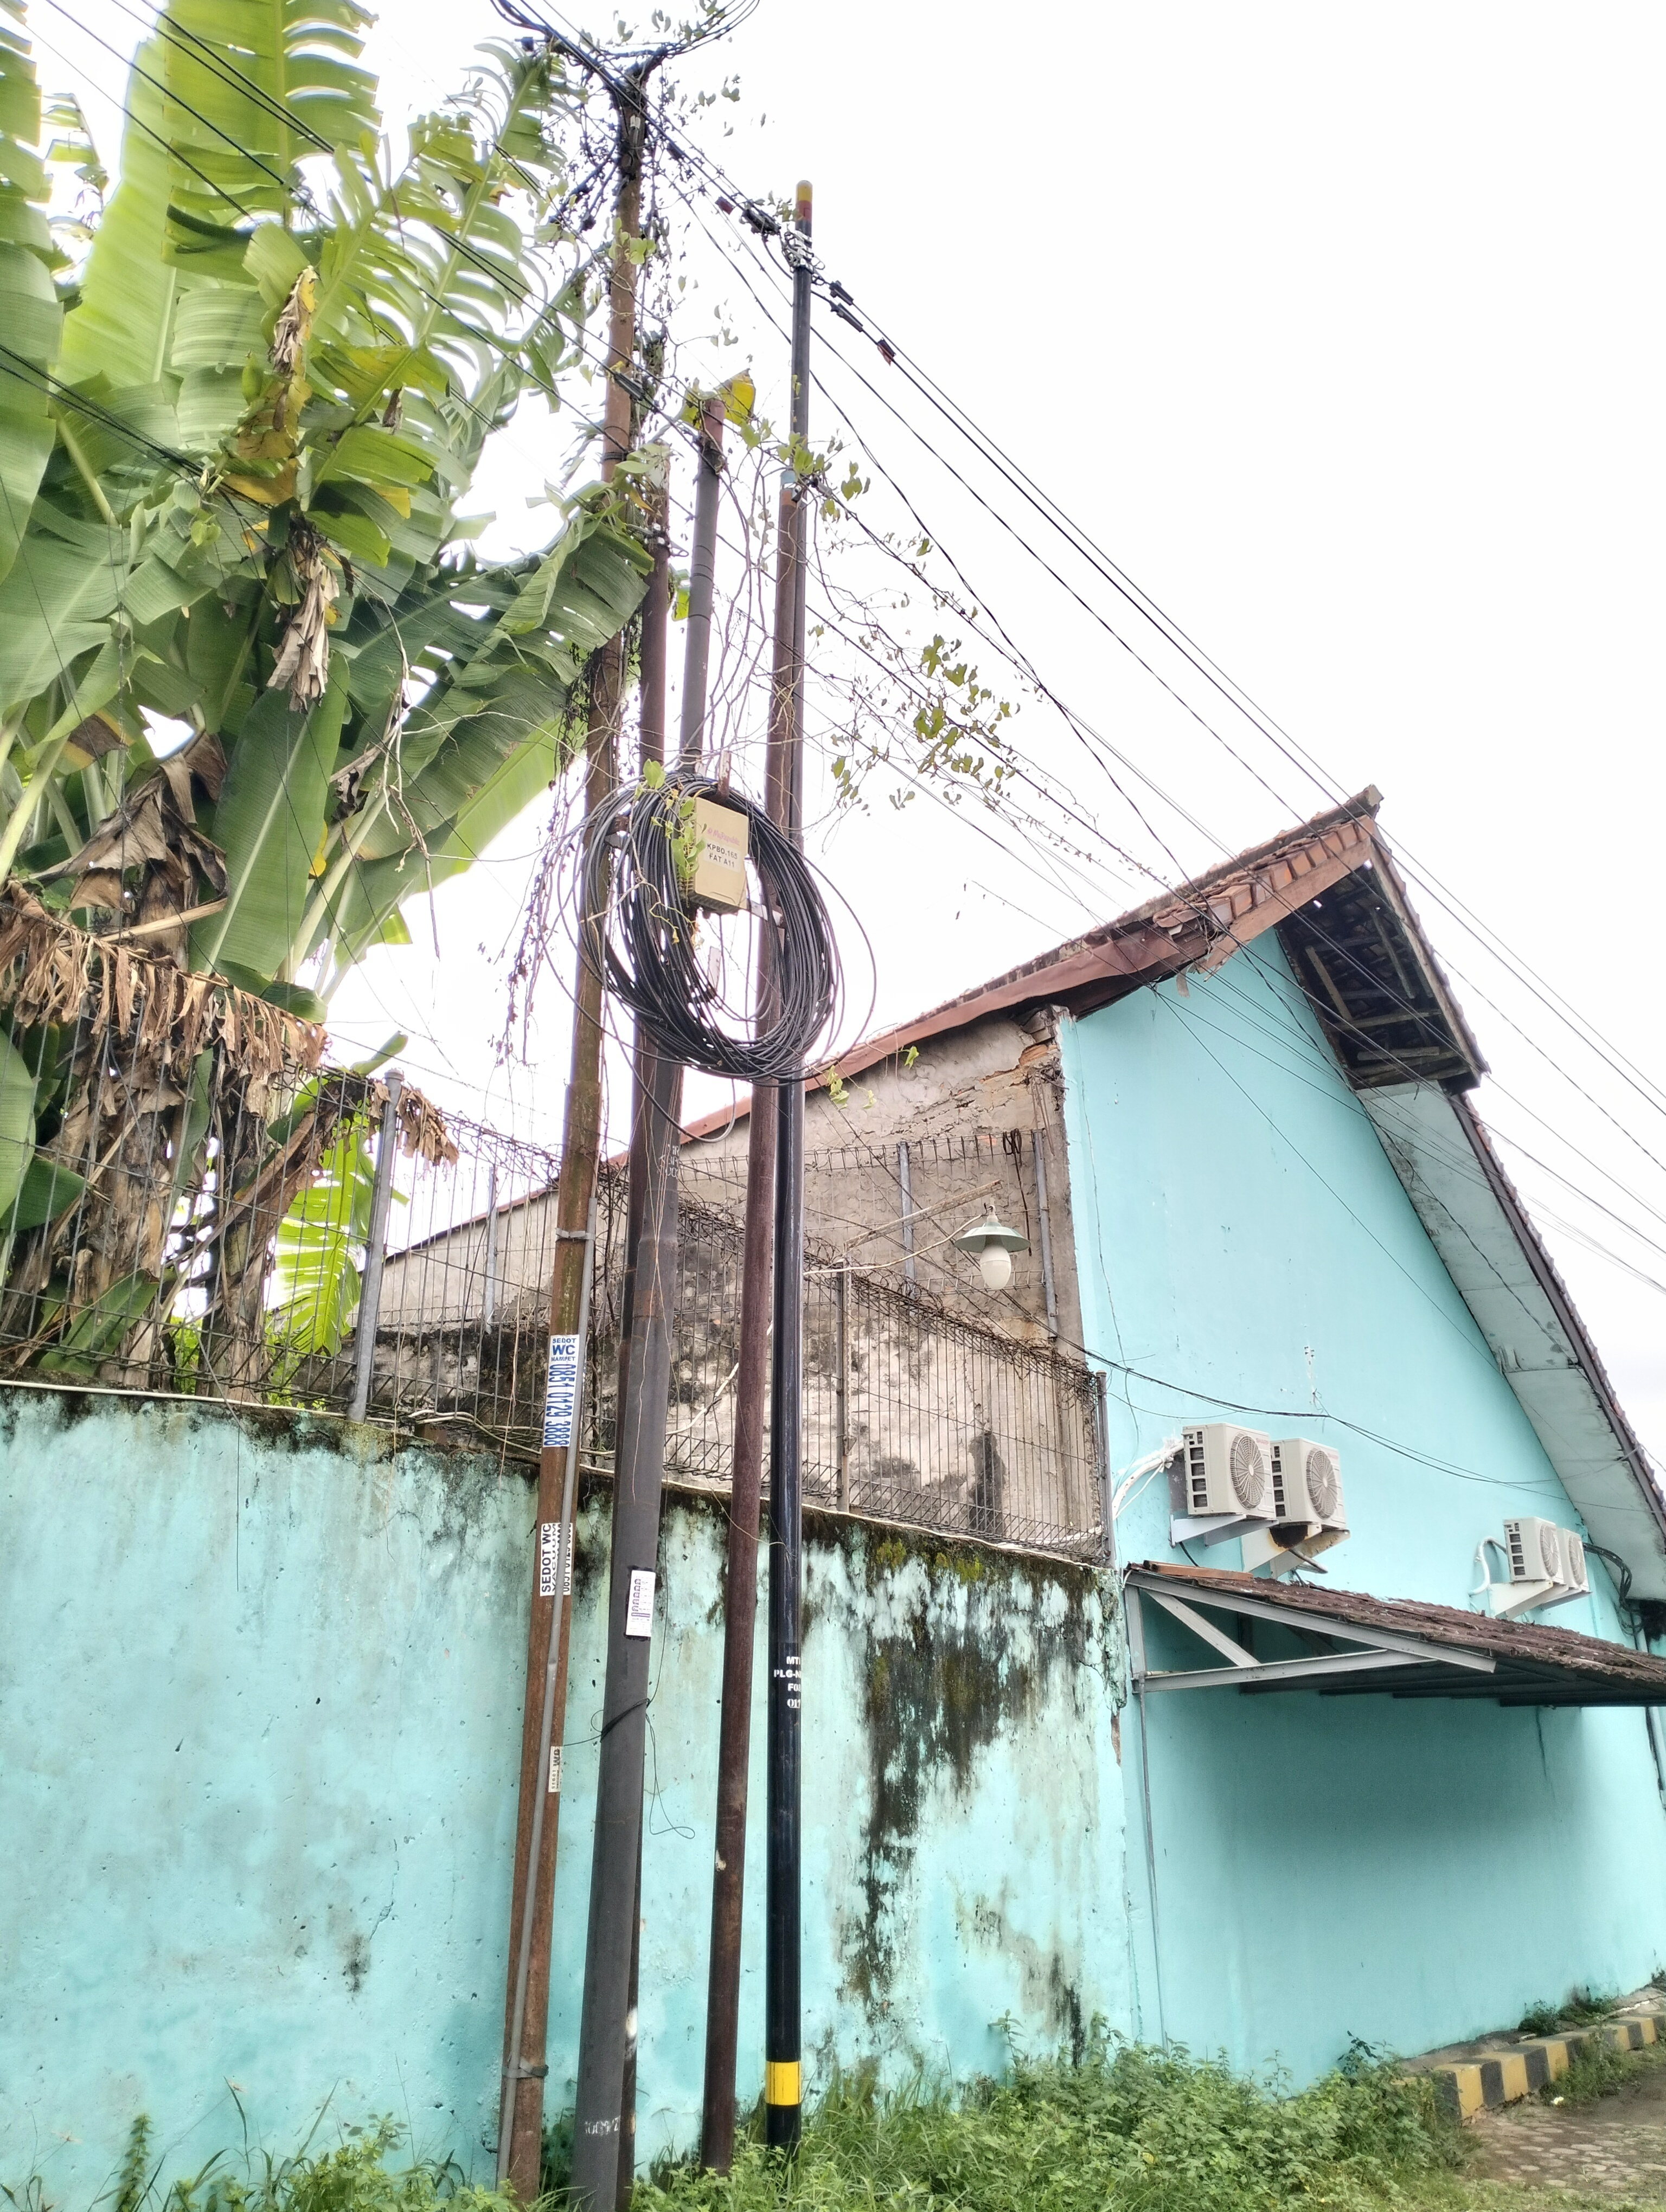

In [ ]:
import glob
import random

# Ambil gambar acak dari dataset validasi untuk tes
test_images = glob.glob(f"{working_dir}/images/val/*")
# Pilih 3 gambar acak
sample_images = random.sample(test_images, 3) if len(test_images) >= 3 else test_images

print("Making predictions on samples...")

results = model_best.predict(
    source=sample_images,
    conf=0.4,       # Confidence threshold (di bawah 40% dianggap noise)
    save=True,      # Simpan gambar hasil
    project="provider-marker",
    name="inference_test",
    exist_ok=True
)

# Tampilkan hasil (Khusus Notebook)
from IPython.display import Image, display

print("\nDetection Result:")
for img_path in glob.glob("/kaggle/working/provider-marker/inference_test/*.jpg"):
    display(Image(filename=img_path, width=600))